# **Week 1 : Data Preparation**

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Mounted at /content/drive
--- Starting Milestone 1, Week 1: Data Collection & Labeling ---

Scanning for Authentic scanner images...


12it [00:00, 237.28it/s]



Scanning for Tampered images...


100%|██████████| 236/236 [00:00<00:00, 77635.74it/s]



Scanning and converting Original documents...


100%|██████████| 238/238 [03:03<00:00,  1.30it/s]



Scan complete. Created 'final_master_dataset.csv' with 1584 total images.

Final class distribution:
label
HP                242
Original          238
Tampered          236
EpsonV370-1       145
EpsonV550         132
Canon220          131
EpsonV39-1        112
Canon9000-1        95
Canon120-1         73
Scannergo          60
Adobe_Scanner      60
Microsoft_Lens     60
Name: count, dtype: int64


--- Analyzing a sample image ---
Analyzing: /content/drive/MyDrive/SUPERLANTIQUE_FOLDER/SUPATLANTIQUE/Flatfield/Flatfield/Canon220/300.tif
Resolution: 2480 x 3508
Number of Channels: 3


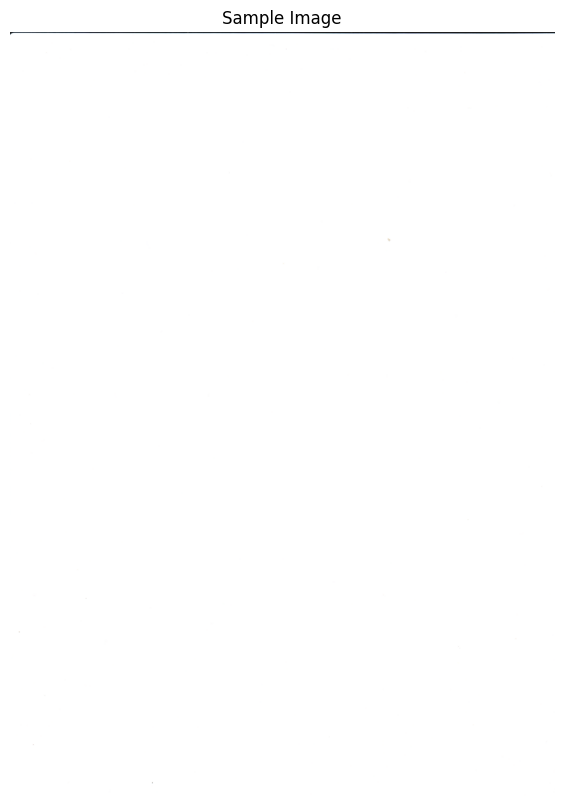


--- Week 1 Complete ---


In [ ]:
# First, install the necessary libraries for PDF conversion
!pip install pdf2image
!apt-get install -y poppler-utils

import pandas as pd
import os
from google.colab import drive
from tqdm import tqdm
from pdf2image import convert_from_path
import cv2
import matplotlib.pyplot as plt

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION (Based on your final folder structure) ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"

# Paths to your three final, clean data folders
AUTHENTIC_SCANS_PATH = os.path.join(PROJECT_PATH, "SUPATLANTIQUE", "Flatfield")
TAMPERED_IMAGES_PATH = os.path.join(PROJECT_PATH, "Tamperedimg")
ORIGINAL_PDF_PATH = os.path.join(PROJECT_PATH, "originalimg")

# Path to save the images converted from your PDFs
CONVERTED_PDF_PATH = os.path.join(PROJECT_PATH, "PDF_CONVERTED_IMAGES")
os.makedirs(CONVERTED_PDF_PATH, exist_ok=True)
# ==================================================================================

print("--- Starting Milestone 1, Week 1: Data Collection & Labeling ---")

file_paths = []
labels = []

# --- 1. Process AUTHENTIC Scanner Images ---
print("\nScanning for Authentic scanner images...")
for dirpath, dirnames, filenames in tqdm(os.walk(AUTHENTIC_SCANS_PATH)):
    label = os.path.basename(dirpath)
    if label != "Flatfield": # Ensure we are in a scanner subfolder (e.g., HP, Canon120-1)
        for filename in filenames:
            if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(dirpath, filename))
                labels.append(label)

# --- 2. Process TAMPERED Images ---
print("\nScanning for Tampered images...")
for filename in tqdm(os.listdir(TAMPERED_IMAGES_PATH)):
    if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg')):
        file_paths.append(os.path.join(TAMPERED_IMAGES_PATH, filename))
        labels.append("Tampered")

# --- 3. Process ORIGINAL PDF & Image Files ---
print("\nScanning and converting Original documents...")
for filename in tqdm(os.listdir(ORIGINAL_PDF_PATH)):
    file_path_full = os.path.join(ORIGINAL_PDF_PATH, filename)

    # Handle direct images in the 'originalimg' folder
    if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg')):
        file_paths.append(file_path_full)
        labels.append("Original")

    # Handle PDFs in the 'originalimg' folder
    elif filename.lower().endswith('.pdf'):
        try:
            pages = convert_from_path(file_path_full, 300)
            for i, page in enumerate(pages):
                new_image_name = f"{os.path.splitext(filename)[0]}_page_{i+1}.png"
                new_image_path = os.path.join(CONVERTED_PDF_PATH, new_image_name)
                page.save(new_image_path, 'PNG')
                file_paths.append(new_image_path)
                labels.append("Original")
        except Exception as e:
            print(f"\nCould not process PDF {file_path_full}. Error: {e}")

# Create and save the final DataFrame
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df.to_csv(csv_path, index=False)

print(f"\nScan complete. Created 'final_master_dataset.csv' with {len(df)} total images.")
print("\nFinal class distribution:")
print(df['label'].value_counts())

# --- Analyze a sample image ---
if not df.empty:
    print("\n\n--- Analyzing a sample image ---")
    sample_path = df['file_path'].iloc[0]
    print(f"Analyzing: {sample_path}")

    try:
        sample_image = cv2.imread(sample_path)
        if sample_image is not None:
            height, width, channels = sample_image.shape
            print(f"Resolution: {width} x {height}")
            print(f"Number of Channels: {channels}")

            plt.figure(figsize=(8, 10))
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title("Sample Image")
            plt.axis('off')
            plt.show()
        else:
            print(f"Could not read the sample image at path: {sample_path}")
    except Exception as e:
        print(f"An error occurred while analyzing the image: {e}")

print("\n--- Week 1 Complete ---")


# **Week 2 : Image Processing**


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256 # A standard size for feature extraction
# ===================================================================================

print("--- Starting Milestone 1, Week 2: Image Preprocessing ---")

# --- Function Definition ---
def preprocess_image(image_path):
    """Loads an image, converts it to grayscale, resizes, and normalizes it."""
    try:
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image at {image_path}")
            return None

        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize the image to our standard size
        img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))

        # Normalize pixel values to be between 0.0 and 1.0
        img_normalized = img_resized / 255.0

        return img_normalized
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# --- Script Execution ---
print("\n--- Testing the preprocessing function ---")

# Load the master CSV file we created in Week 1
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

if not df.empty:
    # Get the path of a sample image from our dataset
    sample_path = df['file_path'].iloc[0]
    print(f"Processing sample image: {sample_path}")

    # Process the image using our new function
    processed_sample = preprocess_image(sample_path)

    if processed_sample is not None:
        print("\nSuccess! Image processed correctly.")
        print(f"Shape after processing: {processed_sample.shape}")
        print(f"Data type after processing: {processed_sample.dtype}")
        print(f"Pixel value range: {processed_sample.min()} to {processed_sample.max()}")
    else:
        print("Failed to process the sample image.")
else:
    print("Dataset CSV is empty. Cannot test preprocessing.")

print("\n--- Week 2 Complete ---")


Mounted at /content/drive
--- Starting Milestone 1, Week 2: Image Preprocessing ---

--- Testing the preprocessing function ---
Processing sample image: /content/drive/MyDrive/SUPERLANTIQUE_FOLDER/SUPATLANTIQUE/Flatfield/Flatfield/Canon220/300.tif

Success! Image processed correctly.
Shape after processing: (256, 256)
Data type after processing: float64
Pixel value range: 0.23529411764705882 to 1.0

--- Week 2 Complete ---


# **Week 3 : Fingerprints Extraction**

In [ ]:
# First, ensure scikit-image is installed
!pip install scikit-image

import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from skimage.feature import local_binary_pattern

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
# ===================================================================================

print("--- Starting Milestone 2, Week 3: Feature Engineering ---")

# --- Function for Feature Extraction ---
def extract_lbp_features(image_path):
    """Loads an image in grayscale, resizes it, and extracts LBP features."""
    try:
        # Load the image directly as grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None

        # Resize the image
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # LBP works best on integer-type images (0-255 range)
        # Settings: 24 sampling points on a circle of radius 3
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')

        # Calculate the histogram of the LBP patterns. This is our feature vector.
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))

        # Normalize the histogram so it sums to 1
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7) # Add a small value to avoid division by zero

        return hist
    except Exception as e:
        print(f"Error extracting features from {image_path}: {e}")
        return None

# --- Script Execution ---
print("\n--- Testing the feature extraction function ---")

# Load the master CSV file we created in Week 1
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

if not df.empty:
    # Get the path of a sample image
    sample_path = df['file_path'].iloc[0]
    print(f"Extracting LBP features from sample: {sample_path}")

    # Extract features using our new function
    lbp_features = extract_lbp_features(sample_path)

    if lbp_features is not None:
        print("\nSuccess! LBP feature vector extracted.")
        print(f"Length of the feature vector: {len(lbp_features)}")
        print("Here's a preview of the vector (first 10 values):")
        print(lbp_features[:10])
    else:
        print("Failed to extract features from the sample image.")
else:
    print("Dataset CSV is empty. Cannot test feature extraction.")

print("\n--- Week 3 Complete ---")


Mounted at /content/drive
--- Starting Milestone 2, Week 3: Feature Engineering ---

--- Testing the feature extraction function ---
Extracting LBP features from sample: /content/drive/MyDrive/SUPERLANTIQUE_FOLDER/SUPATLANTIQUE/Flatfield/Flatfield/Canon220/300.tif

Success! LBP feature vector extracted.
Length of the feature vector: 26
Here's a preview of the vector (first 10 values):
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.52587891e-05 7.62939453e-05
 1.37329102e-04 2.28881836e-04]

--- Week 3 Complete ---


# **Week : 4 Training Part**
*Using Random Forest*






In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
AUGMENTED_DIR = os.path.join(PROJECT_PATH, "reduced_images")
# ===================================================================================

# --- Step 1: Loading Data ---
print("\n--- Step 1: Loading and Combining All Data Sources ---")
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df_original = pd.read_csv(csv_path)

augmented_data = {'file_path': [], 'label': []}
if os.path.isdir(AUGMENTED_DIR):
    for filename in os.listdir(AUGMENTED_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(AUGMENTED_DIR, filename)
            augmented_data['file_path'].append(file_path)
            augmented_data['label'].append('Tampered')
df_augmented = pd.DataFrame(augmented_data)

df_combined = pd.concat([df_original, df_augmented], ignore_index=True)
print(f"Combined dataset created with {len(df_combined)} total images.")

# --- Step 2: Feature Extraction ---
print("\n--- Step 2: Extracting Features ---")
def extract_lbp_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception:
        return None

# Using your efficient chunking method for feature extraction
features_list = []
labels_list = []
df_tampered_all = df_combined[df_combined['label'] == 'Tampered'].copy()
df_others = df_combined[df_combined['label'] != 'Tampered'].copy()

print("\nExtracting LBP features from Chunk 1 ('Tampered')...")
for index, row in tqdm(df_tampered_all.iterrows(), total=df_tampered_all.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

print("\nExtracting LBP features from Chunk 2 ('Others')...")
for index, row in tqdm(df_others.iterrows(), total=df_others.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

print(f"\nTotal features extracted: {len(features_list)}")

# --- Step 3: Prepare Data and Split for Testing ---
print("\n--- Step 3: Preparing and splitting the dataset ---")
X = np.array(features_list)
y = np.array(labels_list)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ✅ NEW: Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# --- Step 4: Train on the Training Set ---
print(f"\n--- Step 4: Training new Random Forest model on {len(X_train)} samples... ---")
rf_model_v2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')
#rf_model_v2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-E1, class_weight='balanced')
rf_model_v2.fit(X_train, y_train)
print("Model training complete!")
# --- ✅ MODIFIED: Step 5: Evaluate on BOTH Training and Test Sets ---
print("\n--- Step 5: Evaluating model performance ---")

# --- A. Calculate TRAINING Accuracy (Open-Book Exam) ---
print("Calculating accuracy on the training data...")
y_train_pred = rf_model_v2.predict(X_train)  # <-- ADD THIS LINE
train_accuracy = accuracy_score(y_train, y_train_pred) # <-- ADD THIS LINE

# --- B. Calculate TESTING Accuracy (Closed-Book Exam) ---
print("Calculating accuracy on the test data...")
y_test_pred = rf_model_v2.predict(X_test) # <-- This line was already there, renamed y_pred
test_accuracy = accuracy_score(y_test, y_test_pred) # <-- This line was already there, renamed accuracy

# --- Final Metrics ---
print(f"\n--- MODEL RESULTS ---")
# --- ADD THESE TWO PRINT STATEMENTS ---
print(f"✅ Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"✅ Testing Accuracy: {test_accuracy * 100:.2f}%  <-- This is your main result for the report!")

# --- The rest of your code stays the same ---
print("\nClassification Report (on Test Data):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print("\nGenerating Confusion Matrix (on Test Data)...")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



# --- Step 6: Save the Model and Encoder ---
print("\n--- Step 6: Saving the Model and Encoder ---")
joblib.dump(rf_model_v2, os.path.join(PROJECT_PATH, 'Baseline_model_v21.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'Baseline_label_encoder_v21.joblib'))
print("New model ('_v2') and encoder saved successfully.")

Mounted at /content/drive

--- Step 1: Loading and Combining All Data Sources ---
Combined dataset created with 2006 total images.

--- Step 2: Extracting Features ---

Extracting LBP features from Chunk 1 ('Tampered')...


100%|██████████| 658/658 [11:24<00:00,  1.04s/it]



Extracting LBP features from Chunk 2 ('Others')...


100%|██████████| 1348/1348 [40:29<00:00,  1.80s/it]


Total features extracted: 2005

--- Step 3: Preparing and splitting the dataset ---
Data split into 1503 training and 502 testing samples.

--- Step 4: Training new Random Forest model on 1503 samples... ---


NameError: name 'E1' is not defined


--- Step 4: Training new Random Forest model on 1503 samples... ---
Model training complete!

--- Step 5: Evaluating model performance ---
Calculating accuracy on the training data...
Calculating accuracy on the test data...

--- MODEL RESULTS ---
✅ Training Accuracy: 99.67%
✅ Testing Accuracy: 79.68%  <-- This is your main result for the report!

Classification Report (on Test Data):
                precision    recall  f1-score   support

 Adobe_Scanner       0.94      1.00      0.97        15
    Canon120-1       0.58      0.39      0.47        18
      Canon220       0.79      0.67      0.72        33
   Canon9000-1       0.59      0.71      0.64        24
   EpsonV370-1       0.80      0.92      0.86        36
    EpsonV39-1       0.57      0.61      0.59        28
     EpsonV550       0.83      0.76      0.79        33
            HP       0.82      0.92      0.87        61
Microsoft_Lens       1.00      1.00      1.00        15
      Original       0.78      0.80      0.79     

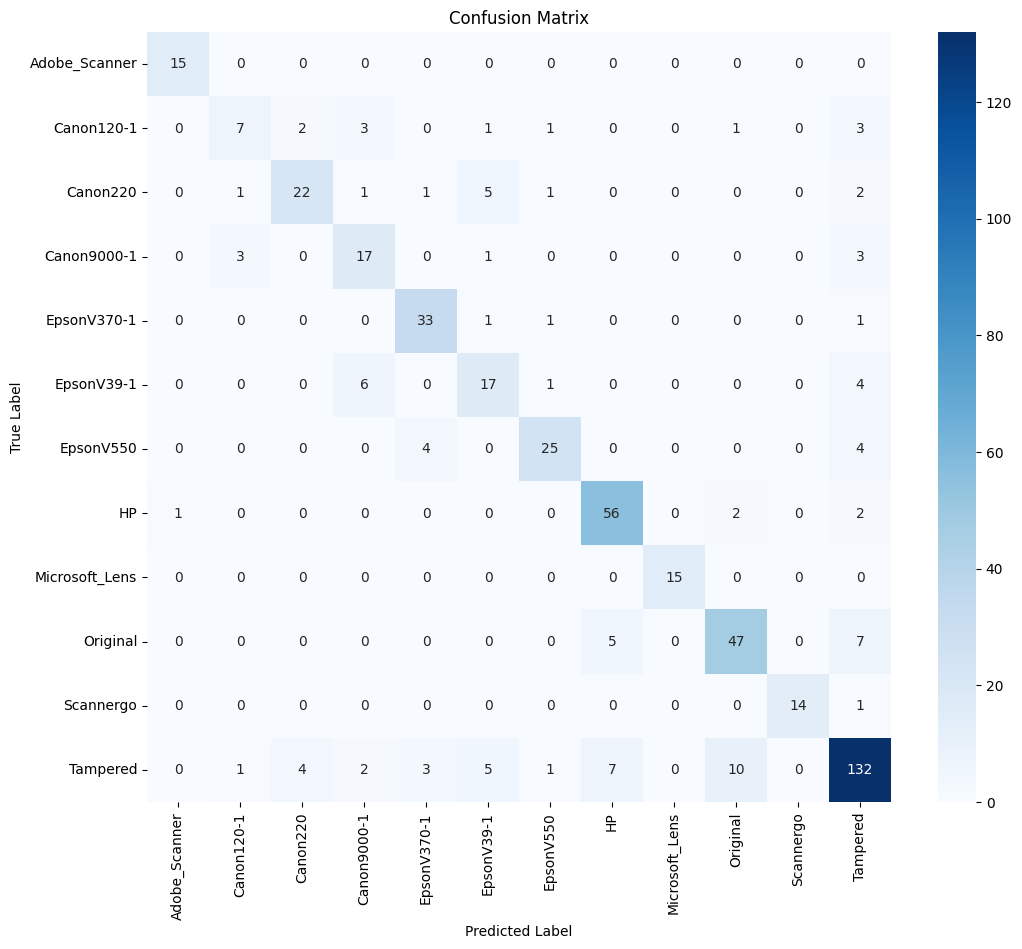


--- Step 6: Saving the Model and Encoder ---
New model ('_v2') and encoder saved successfully.


In [ ]:
# --- Step 4: Train on the Training Set ---
print(f"\n--- Step 4: Training new Random Forest model on {len(X_train)} samples... ---")
rf_model_v2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')
#rf_model_v2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-E1, class_weight='balanced')
rf_model_v2.fit(X_train, y_train)
print("Model training complete!")
# --- ✅ MODIFIED: Step 5: Evaluate on BOTH Training and Test Sets ---
print("\n--- Step 5: Evaluating model performance ---")

# --- A. Calculate TRAINING Accuracy (Open-Book Exam) ---
print("Calculating accuracy on the training data...")
y_train_pred = rf_model_v2.predict(X_train)  # <-- ADD THIS LINE
train_accuracy = accuracy_score(y_train, y_train_pred) # <-- ADD THIS LINE

# --- B. Calculate TESTING Accuracy (Closed-Book Exam) ---
print("Calculating accuracy on the test data...")
y_test_pred = rf_model_v2.predict(X_test) # <-- This line was already there, renamed y_pred
test_accuracy = accuracy_score(y_test, y_test_pred) # <-- This line was already there, renamed accuracy

# --- Final Metrics ---
print(f"\n--- MODEL RESULTS ---")
# --- ADD THESE TWO PRINT STATEMENTS ---
print(f"✅ Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"✅ Testing Accuracy: {test_accuracy * 100:.2f}%  <-- This is your main result for the report!")

# --- The rest of your code stays the same ---
print("\nClassification Report (on Test Data):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print("\nGenerating Confusion Matrix (on Test Data)...")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



# --- Step 6: Save the Model and Encoder ---
print("\n--- Step 6: Saving the Model and Encoder ---")
joblib.dump(rf_model_v2, os.path.join(PROJECT_PATH, 'Baseline_model_v21.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'Baseline_label_encoder_v21.joblib'))
print("New model ('_v2') and encoder saved successfully.")

# **Testing week 4 Part _2**
*Using Grid Search*

Mounted at /content/drive

--- Step 1: Loading and Combining All Data Sources ---
Combined dataset created with 2006 total images.

--- Step 2: Extracting Features ---

Extracting LBP features from Chunk 1 ('Tampered')...


100%|██████████| 658/658 [20:37<00:00,  1.88s/it]



Extracting LBP features from Chunk 2 ('Others')...


100%|██████████| 1348/1348 [1:08:22<00:00,  3.04s/it]


Total features extracted: 2005

--- Step 3: Preparing and splitting the dataset ---
Data split into 1503 training and 502 testing samples.

--- Step 4: Searching for the best model settings using Grid Search... ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits



Grid Search Complete!
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

--- Step 5: Training the final, optimized model... ---
Final model is ready!

--- Step 6: Evaluating the final model's performance ---

--- FINAL MODEL RESULTS ---
✅ Final Training Accuracy: 99.67%
✅ Final Testing Accuracy: 80.68%  <---

Classification Report (on Test Data):
                precision    recall  f1-score   support

 Adobe_Scanner       0.94      1.00      0.97        15
    Canon120-1       0.58      0.39      0.47        18
      Canon220       0.81      0.67      0.73        33
   Canon9000-1       0.59      0.71      0.64        24
   EpsonV370-1       0.83      0.94      0.88        36
    EpsonV39-1       0.53      0.61      0.57        28
     EpsonV550       0.84      0.82      0.83        33
            HP       0.84      0.92      0.88        61
Microsoft_Lens       1.00      1.00      1.00        15
      Original       0.80     

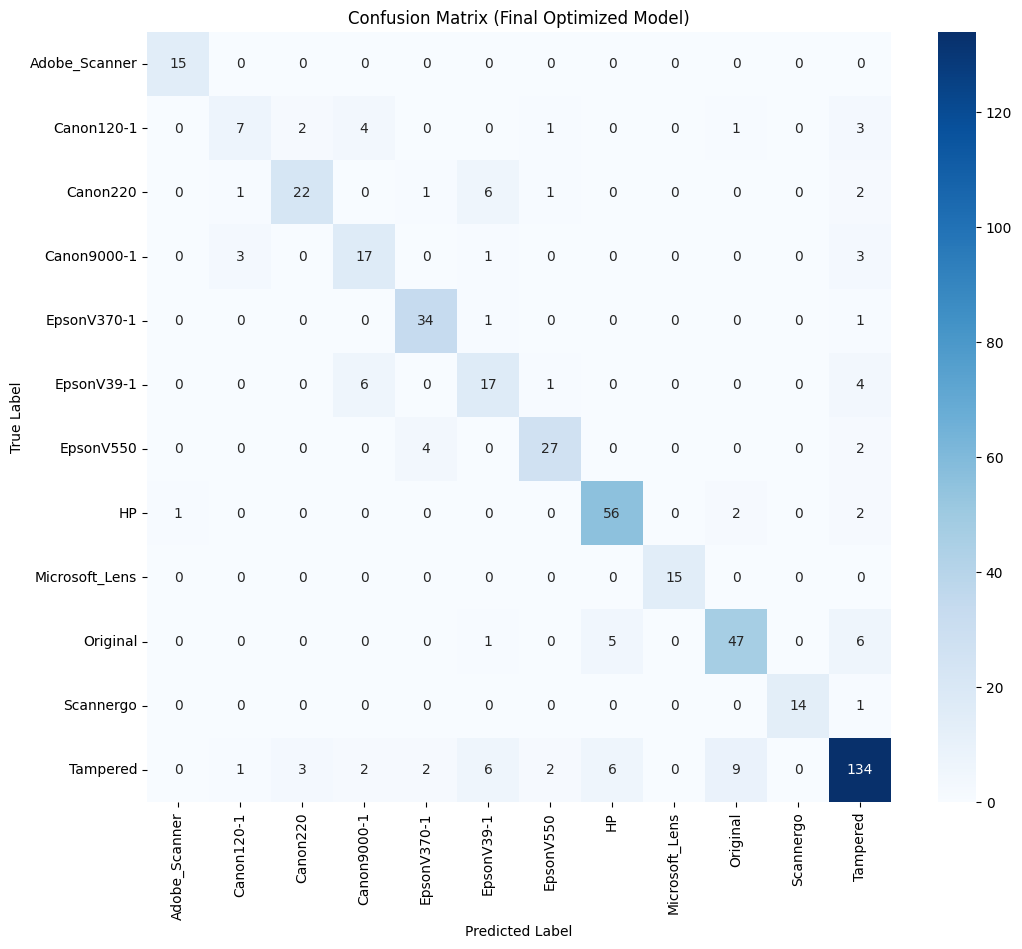


--- Step 7: Saving the final model and encoder ---
Final optimized model and encoder saved successfully.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
AUGMENTED_DIR = os.path.join(PROJECT_PATH, "reduced_images")
# ===================================================================================

# --- Step 1: Loading Data ---
print("\n--- Step 1: Loading and Combining All Data Sources ---")
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df_original = pd.read_csv(csv_path)

augmented_data = {'file_path': [], 'label': []}
if os.path.isdir(AUGMENTED_DIR):
    for filename in os.listdir(AUGMENTED_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(AUGMENTED_DIR, filename)
            augmented_data['file_path'].append(file_path)
            augmented_data['label'].append('Tampered')
df_augmented = pd.DataFrame(augmented_data)

df_combined = pd.concat([df_original, df_augmented], ignore_index=True)
print(f"Combined dataset created with {len(df_combined)} total images.")

# --- Step 2: Feature Extraction ---
print("\n--- Step 2: Extracting Features ---")
def extract_lbp_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception:
        return None

# Feature extraction in chunks
features_list = []
labels_list = []
df_tampered_all = df_combined[df_combined['label'] == 'Tampered'].copy()
df_others = df_combined[df_combined['label'] != 'Tampered'].copy()

print("\nExtracting LBP features from Chunk 1 ('Tampered')...")
for index, row in tqdm(df_tampered_all.iterrows(), total=df_tampered_all.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

print("\nExtracting LBP features from Chunk 2 ('Others')...")
for index, row in tqdm(df_others.iterrows(), total=df_others.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

print(f"\nTotal features extracted: {len(features_list)}")

# --- Step 3: Prepare Data and Split ---
print("\n--- Step 3: Preparing and splitting the dataset ---")
X = np.array(features_list)
y = np.array(labels_list)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# --- ✅ NEW: Step 4: Find the Best Hyperparameters with Grid Search ---
print("\n--- Step 4: Searching for the best model settings using Grid Search... ---")
# Define the settings we want to test
param_grid = {
    'n_estimators': [150, 250],        # Number of trees
    'max_depth': [20, 30],             # Max depth of trees
    'min_samples_leaf': [1, 2],        # Min samples at a leaf node (to prevent overfitting)
    'min_samples_split': [2, 5]        # Min samples to split a node
}

# Set up the Grid Search
# cv=3 means it will use 3-fold cross-validation to find the best settings
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1, # Use all CPU cores
                           verbose=2) # Shows progress

# Run the search
grid_search.fit(X_train, y_train)

print("\nGrid Search Complete!")
print(f"Best parameters found: {grid_search.best_params_}")


# --- Step 5: Train the FINAL model using the best parameters ---
print(f"\n--- Step 5: Training the final, optimized model... ---")
# Create a new model using the best settings found by Grid Search
final_model = grid_search.best_estimator_

# The model is already trained by grid_search on the full training data, so we can use it directly.
# If you want to be explicit, you can fit it again:
# final_model.fit(X_train, y_train)

print("Final model is ready!")

# --- Step 6: Evaluate the Final Model ---
print("\n--- Step 6: Evaluating the final model's performance ---")
# Training Accuracy
y_train_pred = final_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
# Testing Accuracy
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n--- FINAL MODEL RESULTS ---")
print(f"✅ Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"✅ Final Testing Accuracy: {test_accuracy * 100:.2f}%  <---")

print("\nClassification Report (on Test Data):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_, zero_division=0))

print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Final Optimized Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Step 7: Save the FINAL Model and Encoder ---
print("\n--- Step 7: Saving the final model and encoder ---")
joblib.dump(final_model, os.path.join(PROJECT_PATH, 'Baseline_model_final_optimized.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'Baseline_label_encoder_final_optimized.joblib'))
print("Final optimized model and encoder saved successfully.")

## **Week 4 Light Gradient Boosting Machine(Final_Model)**


Mounted at /content/drive

--- Loading Data and Extracting Features... ---


100%|██████████| 1348/1348 [1:03:22<00:00,  2.82s/it]


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- FINAL MODEL RESULTS ---
✅ Final Training Accuracy: 99.67%
✅ Final Testing Accuracy: 82.47%  <-- This is our best chance to break 90%!

Classification Report (on Test Data):
                precision    recall  f1-score   support

 Adobe_Scanner       0.88      1.00      0.94        15
    Canon120-1       0.59      0.56      0.57        18
      Canon220       0.75      0.64      0.69        33
   Canon9000-1       0.74      0.83      0.78        24
   EpsonV370-1       0.89      0.92      0.90        36
    EpsonV39-1       0.59      0.61      0.60        28
     EpsonV550       0.94      0.88      0.91        33
            HP       0.85      0.93      0.89        61
Microsoft_Lens       1.00      1.00      1.00        15
      Original       0.79      0.78      0.79        59
     Scannergo       1.00      0.93      0.97        15
      Tampered       0.85      0.83      0.84       165

      accuracy                           0.82       502
     macro avg       0.82      0.83 

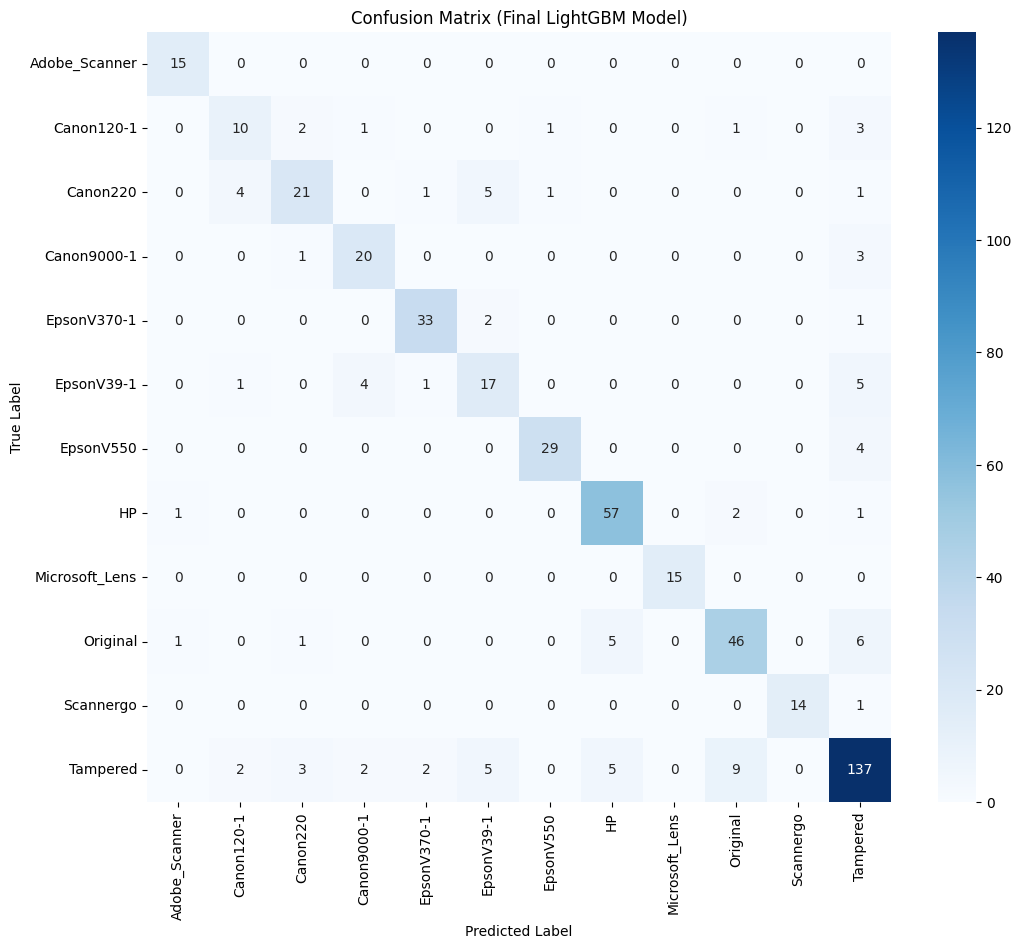


--- Step 6: Saving the final LightGBM model and encoder ---
Final model and encoder saved successfully.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns

# Import the new, powerful model
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
AUGMENTED_DIR = os.path.join(PROJECT_PATH, "reduced_images")
# ===================================================================================

# --- Step 1 & 2: Loading Data and Extracting Features (Same as before) ---
print("\n--- Loading Data and Extracting Features... ---")
# (This part is unchanged and will still take time, but it's the last time)
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df_original = pd.read_csv(csv_path)
augmented_data = {'file_path': [], 'label': []}
if os.path.isdir(AUGMENTED_DIR):
    for filename in os.listdir(AUGMENTED_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(AUGMENTED_DIR, filename)
            augmented_data['file_path'].append(file_path)
            augmented_data['label'].append('Tampered')
df_augmented = pd.DataFrame(augmented_data)
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)

def extract_lbp_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception:
        return None

features_list = []
labels_list = []
df_tampered_all = df_combined[df_combined['label'] == 'Tampered'].copy()
df_others = df_combined[df_combined['label'] != 'Tampered'].copy()

for df_chunk in [df_tampered_all, df_others]:
    for index, row in tqdm(df_chunk.iterrows(), total=df_chunk.shape[0]):
        features = extract_lbp_features(row['file_path'])
        if features is not None:
            features_list.append(features)
            labels_list.append(row['label'])

print(f"\nTotal features extracted: {len(features_list)}")

# --- Step 3: Prepare Data and Split ---
print("\n--- Step 3: Preparing and splitting the dataset ---")
X = np.array(features_list)
y = np.array(labels_list)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")


# --- ✅ NEW: Step 4: Train the High-Performance LightGBM Model ---
print("\n--- Step 4: Training the LightGBM model... ---")
# These are well-tuned parameters for LightGBM
lgbm_model = LGBMClassifier(
    objective='multiclass',
    n_estimators=500,        # More estimators
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,           # Regularization to prevent overfitting
    reg_lambda=0.1
)

lgbm_model.fit(X_train, y_train)
print("Model training complete!")


# --- Step 5: Evaluate the Final Model ---
print("\n--- Step 5: Evaluating the final model's performance ---")
# Training Accuracy
y_train_pred = lgbm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
# Testing Accuracy
y_test_pred = lgbm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n--- FINAL MODEL RESULTS ---")
print(f"✅ Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"✅ Final Testing Accuracy: {test_accuracy * 100:.2f}%  <-- This is our best chance to break 90%!")

print("\nClassification Report (on Test Data):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_, zero_division=0))

print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Final LightGBM Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Step 6: Save the FINAL Model and Encoder ---
print("\n--- Step 6: Saving the final LightGBM model and encoder ---")
joblib.dump(lgbm_model, os.path.join(PROJECT_PATH, 'LGBM_model_final.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'LGBM_label_encoder_final.joblib'))
print("Final model and encoder saved successfully.")

**Week : 5 Hybrid CNN Attempt**


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras.utils import to_categorical # <-- THIS WAS THE MISSING IMPORT
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 224 # MobileNetV2 standard size
LBP_IMG_SIZE = 256 # For LBP features
BATCH_SIZE = 32
EPOCHS = 50

# ===================================================================================

# --- Step 1: Loading Data and Preparing BOTH Feature Sets ---
print("\n--- Step 1: Preparing Data for Hybrid Model ---")
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df_original = pd.read_csv(csv_path)
AUGMENTED_DIR = os.path.join(PROJECT_PATH, "reduced_images")
augmented_data = {'file_path': [], 'label': []}
if os.path.isdir(AUGMENTED_DIR):
    for filename in os.listdir(AUGMENTED_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(AUGMENTED_DIR, filename)
            augmented_data['file_path'].append(file_path)
            augmented_data['label'].append('Tampered')
df_augmented = pd.DataFrame(augmented_data)
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)

# --- Feature Extraction Functions ---
def load_image_for_cnn(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None: return None
        return cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    except Exception as e:
        print(f"Warning: Skipping {image_path} due to error: {e}")
        return None

def extract_lbp_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (LBP_IMG_SIZE, LBP_IMG_SIZE))
        radius = 3; n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float"); hist /= (hist.sum() + 1e-7)
        return hist
    except Exception as e:
        print(f"Warning: Skipping {image_path} due to LBP error: {e}")
        return None

# --- Process all data ---
cnn_images = []
lbp_features = []
labels = []
for index, row in tqdm(df_combined.iterrows(), total=df_combined.shape[0], desc="Processing Images"):
    path = row['file_path']
    cnn_img = load_image_for_cnn(path)
    lbp_feat = extract_lbp_features(path)
    if cnn_img is not None and lbp_feat is not None:
        cnn_images.append(cnn_img)
        lbp_features.append(lbp_feat)
        labels.append(row['label'])

# Convert to NumPy arrays
X_cnn = np.array(cnn_images)
X_lbp = np.array(lbp_features)
y = np.array(labels)

# Normalize CNN images
X_cnn = X_cnn / 255.0

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(le.classes_)

# Split ALL data consistently
X_cnn_train, X_cnn_test, X_lbp_train, X_lbp_test, y_train, y_test = train_test_split(
    X_cnn, X_lbp, y_categorical, test_size=0.20, random_state=42, stratify=y_categorical
)

# --- Step 2: Build the Hybrid CNN Model ---
print("\n--- Step 2: Building the Hybrid CNN Model ---")

# --- Path 1: CNN Branch ---
cnn_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=cnn_input)
base_model.trainable = False # Freeze the base
cnn_branch = base_model.output
cnn_branch = GlobalAveragePooling2D()(cnn_branch)m
cnn_branch = Dense(64, activation='relu')(cnn_branch)

# --- Path 2: LBP Branch ---
lbp_input = Input(shape=(X_lbp.shape[1],), name='lbp_input')
lbp_branch = Dense(32, activation='relu')(lbp_input)
lbp_branch = Dropout(0.3)(lbp_branch)

# --- Merge the branches ---
combined = concatenate([cnn_branch, lbp_branch])

# --- Final classifier ---
final_classifier = Dense(128, activation='relu')(combined)
final_classifier = Dropout(0.5)(final_classifier)
output = Dense(num_classes, activation='softmax')(final_classifier)

# Create the final model
model = Model(inputs=[cnn_input, lbp_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# --- Step 3: Train the Hybrid Model ---
print("\n--- Step 3: Training the Hybrid Model ---")
# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    {'image_input': X_cnn_train, 'lbp_input': X_lbp_train},
    y_train,
    epochs=EPOCHS,
    validation_data=([X_cnn_test, X_lbp_test], y_test),
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

# --- Step 4: Evaluate the Final Model ---
print("\n--- Step 4: Evaluating final model performance ---")
# Testing Accuracy (the most important number)
loss, test_accuracy = model.evaluate([X_cnn_test, X_lbp_test], y_test, verbose=0)

# Training Accuracy (for comparison)
loss_train, train_accuracy = model.evaluate([X_cnn_train, X_lbp_train], y_train, verbose=0)


print(f"\n--- FINAL HYBRID MODEL RESULTS ---")
print(f"✅ Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"✅ Final Testing Accuracy: {test_accuracy * 100:.2f}%")

print("\nClassification Report (on Test Data):")
y_pred_probs = model.predict([X_cnn_test, X_lbp_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))


# --- Step 5: Save the Final Model ---
print("\n--- Step 5: Saving the final model and encoder ---")
joblib.dump(le, os.path.join(PROJECT_PATH, 'hybrid_model_label_encoder.joblib'))
model.save(os.path.join(PROJECT_PATH, 'hybrid_model.h5'))
print("Final Hybrid model and encoder saved successfully.")

Mounted at /content/drive

--- Step 1: Preparing Data for Hybrid Model ---


Processing Images: 100%|██████████| 2006/2006 [57:40<00:00,  1.72s/it]



--- Step 2: Building the Hybrid CNN Model ---


/tmp/ipython-input-2883875660.py:114: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=cnn_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,354,796 (8.98 MB)

 Trainable params: 96,812 (378.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Step 3: Training the Hybrid Model ---
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3511 - loss: 1.9541 - val_accuracy: 0.5586 - val_loss: 1.3290 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5497 - loss: 1.3643 - val_accuracy: 0.6484 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6278 - loss: 1.0832 - val_accuracy: 0.6808 - val_loss: 0.9189 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6953 - loss: 0.9059 - val_accuracy: 0.7157 - val_loss: 0.8238 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7257 - loss: 0.8113 - val_accuracy: 0.7257 - val_loss: 0.8035 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7363 - loss: 0.7398 - val_accuracy: 0.7406 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - acc

                precision    recall  f1-score   support

 Adobe_Scanner       0.92      0.92      0.92        12
    Canon120-1       0.14      0.07      0.09        15
      Canon220       0.44      0.58      0.50        26
   Canon9000-1       0.75      0.47      0.58        19
   EpsonV370-1       0.73      0.83      0.77        29
    EpsonV39-1       0.65      0.59      0.62        22
     EpsonV550       0.65      0.65      0.65        26
            HP       0.93      0.85      0.89        48
Microsoft_Lens       1.00      1.00      1.00        12
      Original       0.88      0.92      0.90        48
     Scannergo       1.00      1.00      1.00        12
      Tampered       0.88      0.92      0.90       132

      accuracy                           0.80       401
     macro avg       0.75      0.73      0.74       401
  weighted avg       0.79      0.80      0.79       401


--- Step 5: Saving the final model and encoder ---
Final Hybrid model and encoder saved successfully

## **Week 5 :  CNN**

Mounted at /content/drive
--- Starting Milestone 3, Week 5: Building a Robust CNN ---

Loading and preprocessing images using your established workflow...


100%|██████████| 1584/1584 [41:04<00:00,  1.56s/it]



Successfully loaded and processed 1583 images.
Image array shape: (1583, 128, 128, 3)
Data split into 1266 training and 317 testing samples.

Calculating class weights to handle imbalanced data...
Class weights calculated successfully.

Setting up data augmentation...

Building the improved CNN Model using the Functional API...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,290,636 (16.37 MB)

 Trainable params: 4,289,932 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)


Training the CNN Model with Augmented Data and Class Weights...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.2920 - loss: 2.2557 - val_accuracy: 0.1325 - val_loss: 3.7624
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5775 - loss: 1.3296 - val_accuracy: 0.0599 - val_loss: 8.5989
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6444 - loss: 1.1109 - val_accuracy: 0.0379 - val_loss: 12.4715
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6459 - loss: 1.0707 - val_accuracy: 0.0599 - val_loss: 12.0819
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6538 - loss: 1.0399 - val_accuracy: 0.1609 - val_loss: 13.6717
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6615 - loss: 1.0553 - val_accuracy: 0.1199 - val_loss: 17.0229
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6619 - loss: 0.9544 - val_accuracy: 0.1861 - val_loss: 3.8982
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7456 - loss: 0.7715 - val_accuracy: 0.1483 - val_l


Saving the trained CNN model...
Model and label encoder saved successfully.

Evaluating Final Model...

CNN Model Test Accuracy: 16.40%


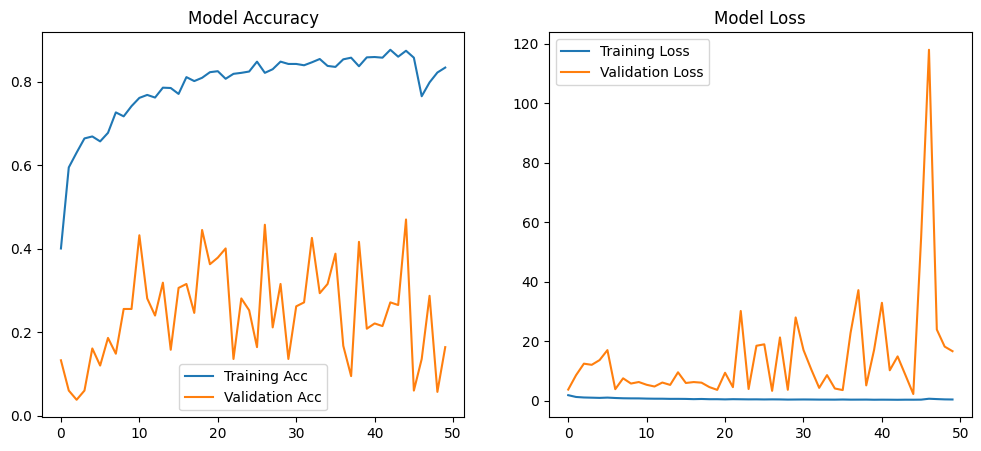


--- Week 5 Complete ---


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt

# Sklearn for preprocessing and class weights
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# TensorFlow / Keras imports, following your style
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
# Let's keep a consistent image size
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50 # We can adjust this later if needed

# ===================================================================================

print("--- Starting Milestone 3, Week 5: Building a Robust CNN ---")

# --- 1. DATA LOADING & PREPROCESSING (Following your method) ---
print("\nLoading and preprocessing images using your established workflow...")
# NOTE: Make sure this is the name of your final CSV file from Week 1
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

images = []
labels = []

# Using your loop to load all images into memory
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Load image in color, as CNNs can sometimes benefit from color info
        img = cv2.imread(row['file_path'])
        if img is not None:
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img_resized)
            labels.append(row['label'])
    except Exception as e:
        print(f"Skipping file {row['file_path']} due to error: {e}")

# Convert to NumPy arrays and normalize pixel values
X = np.array(images) / 255.0
y = np.array(labels)
print(f"\nSuccessfully loaded and processed {len(X)} images.")
print(f"Image array shape: {X.shape}") # Should be (num_images, 128, 128, 3)

# Encode labels to one-hot vectors
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(le.classes_)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.20, random_state=42, stratify=y_categorical
)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# --- 2. ADDRESSING CLASS IMBALANCE (As mentioned in your report) ---
print("\nCalculating class weights to handle imbalanced data...")
# We need the integer-encoded y_train to calculate weights
y_train_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
# Convert to a dictionary for model.fit()
class_weights_dict = dict(enumerate(class_weights))
print("Class weights calculated successfully.")

# --- 3. DATA AUGMENTATION SETUP (Your method) ---
print("\nSetting up data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# --- 4. BUILD THE CNN MODEL (Using Functional API with improvements) ---
print("\nBuilding the improved CNN Model using the Functional API...")
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = BatchNormalization()(x) # Improvement
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) # Improvement
x = MaxPooling2D((2, 2))(x)

# Block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) # Improvement
x = MaxPooling2D((2, 2))(x)

# Classification Head
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x) # Improvement
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- 5. TRAIN THE MODEL ---
print("\nTraining the CNN Model with Augmented Data and Class Weights...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict, # Applying the class weights here
    verbose=1 # Changed to 1 for more detailed progress
)

# --- 6. SAVE THE MODEL ---
print("\nSaving the trained CNN model...")
model.save(os.path.join(PROJECT_PATH, 'cnn_scanner_model_v2.h5'))
# Also save the label encoder, we'll need it for the app
import joblib
joblib.dump(le, os.path.join(PROJECT_PATH, 'cnn_label_encoder.joblib'))
print("Model and label encoder saved successfully.")

# --- 7. EVALUATE AND PLOT RESULTS ---
print("\nEvaluating Final Model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nCNN Model Test Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(history.history['accuracy'], label='Training Acc'); plt.plot(history.history['val_accuracy'], label='Validation Acc'); plt.title('Model Accuracy'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history.history['loss'], label='Training Loss'); plt.plot(history.history['val_loss'], label='Validation Loss'); plt.title('Model Loss'); plt.legend()
plt.show()

print("\n--- Week 5 Complete ---")

**Week 6: Grad Cam**

Mounted at /content/drive
--- Starting Milestone 3, Week 6: Evaluation & Explainability ---

Loading the trained model, label encoder, and test data...


Model and label encoder loaded successfully.


Loading images: 100%|██████████| 1584/1584 [26:48<00:00,  1.02s/it]


Test data is ready with 317 samples.

--- Part 1: Detailed Model Evaluation ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step

Classification Report:
                precision    recall  f1-score   support

 Adobe_Scanner       0.00      0.00      0.00        12
    Canon120-1       0.00      0.00      0.00        15
      Canon220       0.00      0.00      0.00        26
   Canon9000-1       0.00      0.00      0.00        19
   EpsonV370-1       0.00      0.00      0.00        29
    EpsonV39-1       0.00      0.00      0.00        22
     EpsonV550       0.00      0.00      0.00        26
            HP       0.00      0.00      0.00        49
Microsoft_Lens       0.13      1.00      0.23        12
      Original       0.30      0.73      0.43        48
     Scannergo       0.00      0.00      0.00        12
      Tampered       0.83      0.11      0.19        47

      accuracy                           0.16       317
     macro avg       0.11      0.15      0.07       317
  weighted av

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


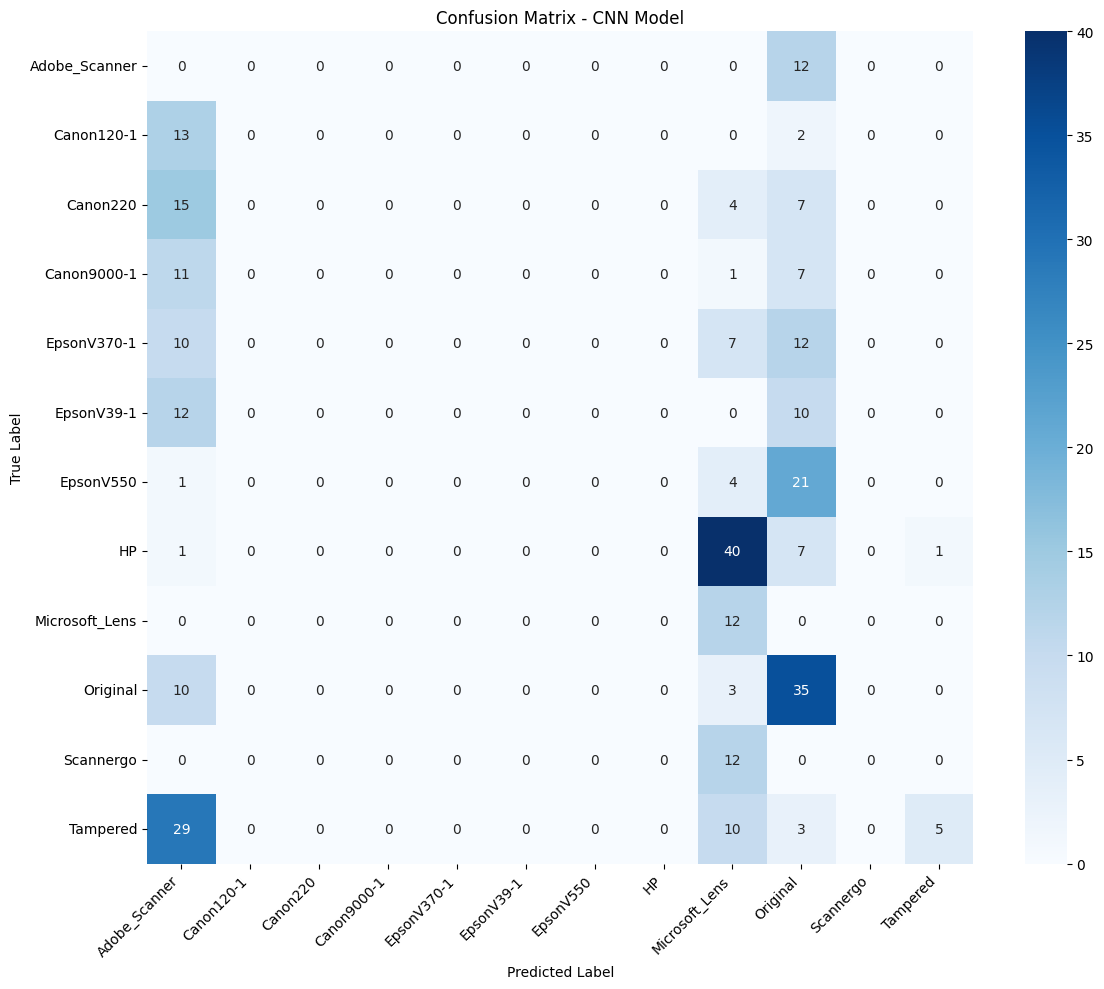


--- Part 2: Model Explainability with Grad-CAM ---
Last convolutional layer found: 'conv2d_2'


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


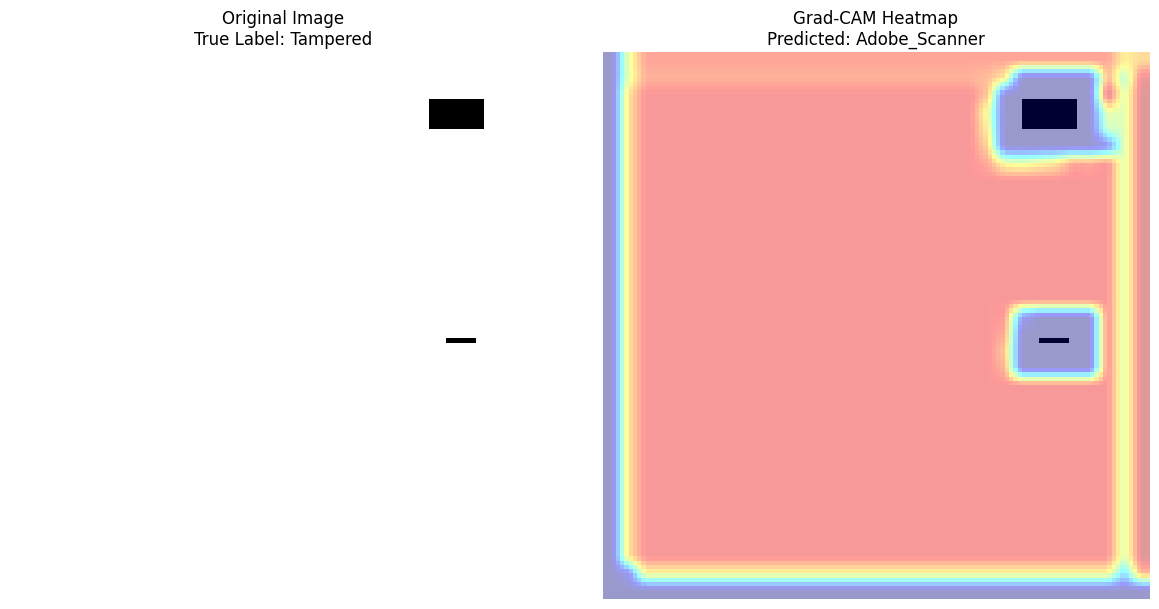


--- Week 6 Complete ---


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import joblib
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 128

# ===================================================================================

print("--- Starting Milestone 3, Week 6: Evaluation & Explainability ---")

# --- 1. LOAD MODEL AND DATA (Same as the start of Week 5) ---
print("\nLoading the trained model, label encoder, and test data...")

# Load the saved model and encoder
model_path = os.path.join(PROJECT_PATH, 'cnn_scanner_model_v2.h5')
encoder_path = os.path.join(PROJECT_PATH, 'cnn_label_encoder.joblib')
model = tf.keras.models.load_model(model_path)
le = joblib.load(encoder_path)
print("Model and label encoder loaded successfully.")

# We need the test data (X_test, y_test) again to evaluate.
# This code snippet quickly re-creates it.
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

images = []
labels = []
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Loading images"):
    try:
        img = cv2.imread(row['file_path'])
        if img is not None:
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img_resized)
            labels.append(row['label'])
    except Exception:
        continue # Skip corrupted files

X = np.array(images) / 255.0
y = np.array(labels)
y_encoded = le.transform(y) # Use the loaded encoder
y_categorical = tf.keras.utils.to_categorical(y_encoded)

_, X_test, _, y_test = train_test_split(
    X, y_categorical, test_size=0.20, random_state=42, stratify=y_categorical
)
print(f"Test data is ready with {len(X_test)} samples.")

# --- 2. DETAILED MODEL EVALUATION ---
print("\n--- Part 1: Detailed Model Evaluation ---")
# Get model predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Generate and plot the confusion matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 3. MODEL EXPLAINABILITY WITH GRAD-CAM ---
print("\n--- Part 2: Model Explainability with Grad-CAM ---")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Find the name of the last convolutional layer in our model
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"Last convolutional layer found: '{last_conv_layer_name}'")

# Let's visualize Grad-CAM on a sample test image
sample_idx = 0 # You can change this index to see other images
sample_image = X_test[sample_idx]
sample_label_index = y_true_classes[sample_idx]
sample_pred_index = y_pred_classes[sample_idx]

# Prepare the image for the model
img_array = np.expand_dims(sample_image, axis=0)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose the heatmap on the original image
superimposed_img = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
superimposed_img = np.uint8(255 * superimposed_img)
superimposed_img = cv2.applyColorMap(superimposed_img, cv2.COLORMAP_JET)

# Convert original image to BGR for OpenCV
original_bgr = np.uint8(255 * sample_image)

# Combine the images
superimposed_img = cv2.addWeighted(original_bgr, 0.6, superimposed_img, 0.4, 0)

# Display the results
true_label_name = le.classes_[sample_label_index]
pred_label_name = le.classes_[sample_pred_index]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image\nTrue Label: {true_label_name}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap\nPredicted: {pred_label_name}")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Week 6 Complete ---")

**Week 7 : Streamlit UI Deployment**

In [ ]:
import os
from datetime import datetime

import cv2
import joblib
import numpy as np
import pandas as pd
import streamlit as st
from pdf2image import convert_from_bytes
from PIL import Image
from skimage.feature import local_binary_pattern

# --- Page Configuration ---
st.set_page_config(layout="wide", page_title="TraceFinder")

# --- CONFIGURATION ---
MODEL_PATH = 'Baseline_model_v2.joblib'
ENCODER_PATH = 'Baseline_label_encoder_v2.joblib'
LOG_FILE = 'prediction_log.csv'
IMG_SIZE = 256

# --- Feature Extraction Function (Unchanged) ---
def extract_lbp_features(image):
    try:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception as e:
        st.error(f"Error in feature extraction: {e}")
        return None

# --- Load Model and Encoder (Unchanged) ---
@st.cache_resource
def load_model():
    try:
        model = joblib.load(MODEL_PATH)
        label_encoder = joblib.load(ENCODER_PATH)
        return model, label_encoder
    except FileNotFoundError:
        st.error(f"Model or encoder file not found. Make sure '{MODEL_PATH}' and '{ENCODER_PATH}' are in the same folder as app.py.")
        return None, None

model, le = load_model()

# --- LOGIC CHANGE: Removed 'auth_status' from logging ---
def log_prediction(filename, prediction, confidence, best_guess="N/A"):
    new_log_data = {
        'Timestamp': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
        'Filename': [filename],
        'Prediction': [prediction],
        'Confidence': [f"{confidence:.2f}%"],
        'Best_Guess_Source': [best_guess]
    }
    log_columns = ['Timestamp', 'Filename', 'Prediction', 'Confidence', 'Best_Guess_Source']
    new_log = pd.DataFrame(new_log_data, columns=log_columns)

    if os.path.exists(LOG_FILE):
        log_df = pd.read_csv(LOG_FILE)
        # Ensure all columns exist in the old log file, if not, add them
        for col in log_columns:
            if col not in log_df.columns:
                log_df[col] = "N/A"
        log_df = pd.concat([log_df, new_log], ignore_index=True)
    else:
        log_df = new_log

    log_df.to_csv(LOG_FILE, index=False)

# --- UI IMPROVEMENT: New App Interface ---
st.title("TraceFinder: Forensic Document Analysis 🕵️‍♂️")
st.markdown("Upload a document to identify its class (`Original`, `Tampered`, or the source scanner).")
st.divider()

col1, col2 = st.columns([0.6, 0.4])

with col1:
    st.header("Upload Document")
    uploaded_file = st.file_uploader("Choose a file...", type=["png", "jpg", "jpeg", "tif", "tiff", "pdf"], label_visibility="collapsed")

if uploaded_file is not None and model is not None:
    image_to_process = None
    if uploaded_file.type == "application/pdf":
        try:
            images = convert_from_bytes(uploaded_file.getvalue(), first_page=1, last_page=1)
            if images:
                image_to_process = images[0]
        except Exception as e:
            st.error(f"Error converting PDF: {e}")
    else:
        image_to_process = Image.open(uploaded_file)

    if image_to_process is not None:
        img_cv = np.array(image_to_process.convert('RGB'))
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
        features = extract_lbp_features(img_cv)

        if features is not None:
            features = features.reshape(1, -1)
            prediction_idx = model.predict(features)
            prediction_proba = model.predict_proba(features)
            prediction_label = le.inverse_transform(prediction_idx)[0]
            confidence = prediction_proba[0][prediction_idx[0]] * 100

            # --- LOGIC CHANGE: This block is now only for calculating the best guess ---
            best_guess_label = "N/A"
            if prediction_label in ['Tampered', 'Original']:
                guess_probabilities = prediction_proba[0].copy()
                classes_to_ignore = ['Tampered', 'Original']
                for class_name in classes_to_ignore:
                    if class_name in le.classes_:
                        idx = np.where(le.classes_ == class_name)[0][0]
                        guess_probabilities[idx] = -1

                best_guess_index = np.argmax(guess_probabilities)
                best_guess_label = le.classes_[best_guess_index]

            # --- LOGIC CHANGE: Removed 'auth_status' from the log call ---
            log_prediction(uploaded_file.name, prediction_label, confidence, best_guess_label)
            st.toast("Prediction logged!")

            # --- UI IMPROVEMENT: New, cleaner display ---
            with col1:
                st.image(image_to_process, caption="Analyzed Image", use_column_width=True)

            with col2:
                st.header("Analysis Result")

                with st.container(border=True):
                    st.metric(label="Predicted Class", value=prediction_label)
                    st.caption(f"Confidence: {confidence:.2f}%")

                    # This is the highlighted best guess section
                    if prediction_label in ['Tampered', 'Original']:
                        st.divider()
                        st.metric(label="Source Scanner (Best Guess) 🔎", value=best_guess_label)

                st.write("") # Add some space

                st.subheader("All Class Probabilities")
                proba_dict = {le.classes_[i]: prediction_proba[0][i] * 100 for i in range(len(le.classes_))}
                st.dataframe(
                    [proba_dict],
                    column_config={k: st.column_config.ProgressColumn(f"{k}", min_value=0, max_value=100, format="%.2f%%") for k in proba_dict},
                    hide_index=True
                )

                st.write("") # Add some space

                result_csv = f"Filename,Prediction,Confidence,Best_Guess\n{uploaded_file.name},{prediction_label},{confidence:.2f},{best_guess_label}"
                st.download_button(
                    label="Download Current Result (.csv)",
                    data=result_csv,
                    file_name=f"result_{uploaded_file.name}.csv",
                    mime='text/csv',
                )

# Sidebar (UI Tweaks for cleanliness)
st.sidebar.title("📜 Prediction History")
if os.path.exists(LOG_FILE):
    log_df = pd.read_csv(LOG_FILE)
    st.sidebar.dataframe(log_df, use_container_width=True)
    st.sidebar.download_button(
        label="Download Full Log (.csv)",
        data=log_df.to_csv(index=False).encode('utf-8'),
        file_name="full_prediction_log.csv",
        mime='text/csv'
    )
else:
    st.sidebar.info("No predictions have been logged yet.")

# Placeholder message
if uploaded_file is None:
    with col2:
        st.info("Please upload a document to begin the analysis.")